In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'integrated_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (integrated)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / dataset_name).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'cell_type'
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V2-104M_CLcancer').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 4
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-12 17:06:59 | Using device cuda


INFO     | 2025-08-12 17:06:59 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study', 'orig.ident']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (138727, 33541)
obs columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']
var columns: []
label_col -> annotation
batch_col -> orig.ident
gene_col -> var.index
n unique labels: 16
label example counts:
 annotation
Epithelial           52081
Unknown              35593
Myeloid              11400
Fibroblast           11155
Malignant             6848
Lymphiod              6591
T_cell                5325
Normal epithelium     4603
Macrophage            1855
B_cell                1106
Endothelial           1049
Pericyte               760
Mast                   227
Dendritic              112
Lymphovascular          16
Plasma                   6
Name: count, dtype: int64


In [6]:
# Load and preprocess data to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col if gene_col else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-12 17:11:55 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad
WARNING  | 2025-08-12 17:13:46 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-12 17:14:05 | Matched 68.68% genes (19794/28819) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.h5ad exists: True


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


... storing 'cell_type' as categorical


Added 'cell_type' column from: annotation
Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.h5ad


In [8]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

dataset_dir = preprocessed_path / f'{dataset_name}.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-12 17:20:36 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 138727
Sample input_ids length: 2495
Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.dataset exists: True
save_to_disk skipped: Tried to overwrite /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence/integrated_with_quiescence.dataset but a dataset can't overwrite itself.
Saved row_order.csv
Saved manifest.json
Archived tokenized dataset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/integrated_with_qui

In [9]:
dataset_dir = preprocessed_path / f'{dataset_name}.dataset'

if dataset_dir.exists():
    geneform.load_tokenized_dataset(str(dataset_dir))
    print('Loaded existing tokenized dataset.')
else:
    geneform.tokenize_data(
        adata_path=str(h5_path),
        dataset_path=str(preprocessed_path),
        cell_type_col=label_col
    )
    print('Tokenized and loaded dataset.')

Loaded existing tokenized dataset.


In [10]:
# Load back, extract embeddings, and quick eval

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings): 100%|██████████| 34682/34682 [3:17:36<00:00,  2.93it/s]  
DEBUG    | 2025-08-12 20:57:28 | Extracting output from 500 cells
WARNING  | 2025-08-12 20:57:41 | adata_ has 138727 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-12 20:57:42 | Computing metrics for annotation
DEBUG    | 2025-08-12 20:57:47 | NMI_cluster/label: 0.4708
ARI_cluster/label: 0.2119
ASW_label: 0.4781
graph_conn: 0.9215
ASW_batch: 0.5463
ASW_label/batch: 0.7386
PCR_batch: 0.1039
avg_bio: 0.3869
DEBUG    | 2025-08-12 20:57:47 | NMI_cluster/label for annotation: 0.47084337513534197
DEBUG    | 2025-08-12 20:57:47 | ARI_cluster/label for annotation: 0.21185959334897644
DEBUG    | 2025-08-12 20:57:47 | ASW_label for annotation: 0.4781028628349304
DEBUG    | 2025-08-12 20:57:47 | graph_conn for annotation: 0.9214948706755429
DEBUG    | 2025-08-12 20:57:47 | ASW_batch for annotation: 0.5462539196014404
DEBUG    | 2025-08-12 20:57:47 | ASW_label/batch for annotation: 0.73861742019

,metric,label,value
0,NMI_cluster/label,annotation,0.470843
1,ARI_cluster/label,annotation,0.211860
2,ASW_label,annotation,0.478103
3,graph_conn,annotation,0.921495
4,ASW_batch,annotation,0.546254
5,ASW_label/batch,annotation,0.738617
6,PCR_batch,annotation,0.103883
7,avg_bio,annotation,0.386935


In [11]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_integrated_results_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_integrated_metrics_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-12 20:57:47 | Initialized GeneformerEnsembleMetrics with 138727 cells and 16 classes
INFO     | 2025-08-12 20:57:47 | Classes: ['B_cell', 'Dendritic', 'Endothelial', 'Epithelial', 'Fibroblast', 'Lymphiod', 'Lymphovascular', 'Macrophage', 'Malignant', 'Mast', 'Myeloid', 'Normal epithelium', 'Pericyte', 'Plasma', 'T_cell', 'Unknown']
INFO     | 2025-08-12 20:57:47 | Embedding shape: (138727, 768)
INFO     | 2025-08-12 20:57:47 | Input rankings length: 138727
INFO     | 2025-08-12 20:57:47 | Output rankings length: 138727
INFO     | 2025-08-12 20:57:48 | Evaluated embedding_only (α=0.0): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.0: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:50 | Evaluated embedding_only (α=0.1): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.1: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:51 | Evaluated embedding_only (α=0.3): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.3: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:52 | Evaluated embedding_only (α=0.5): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.5: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:54 | Evaluated embedding_only (α=0.7): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.7: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:55 | Evaluated embedding_only (α=0.9): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=0.9: F1=0.602, AUC=0.867, Acc=0.586


INFO     | 2025-08-12 20:57:56 | Evaluated embedding_only (α=1.0): Accuracy=0.586, F1=0.602, AUC-ROC=0.867


alpha=1.0: F1=0.602, AUC=0.867, Acc=0.586
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_results_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_metrics_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_confusion_matrix_full.png


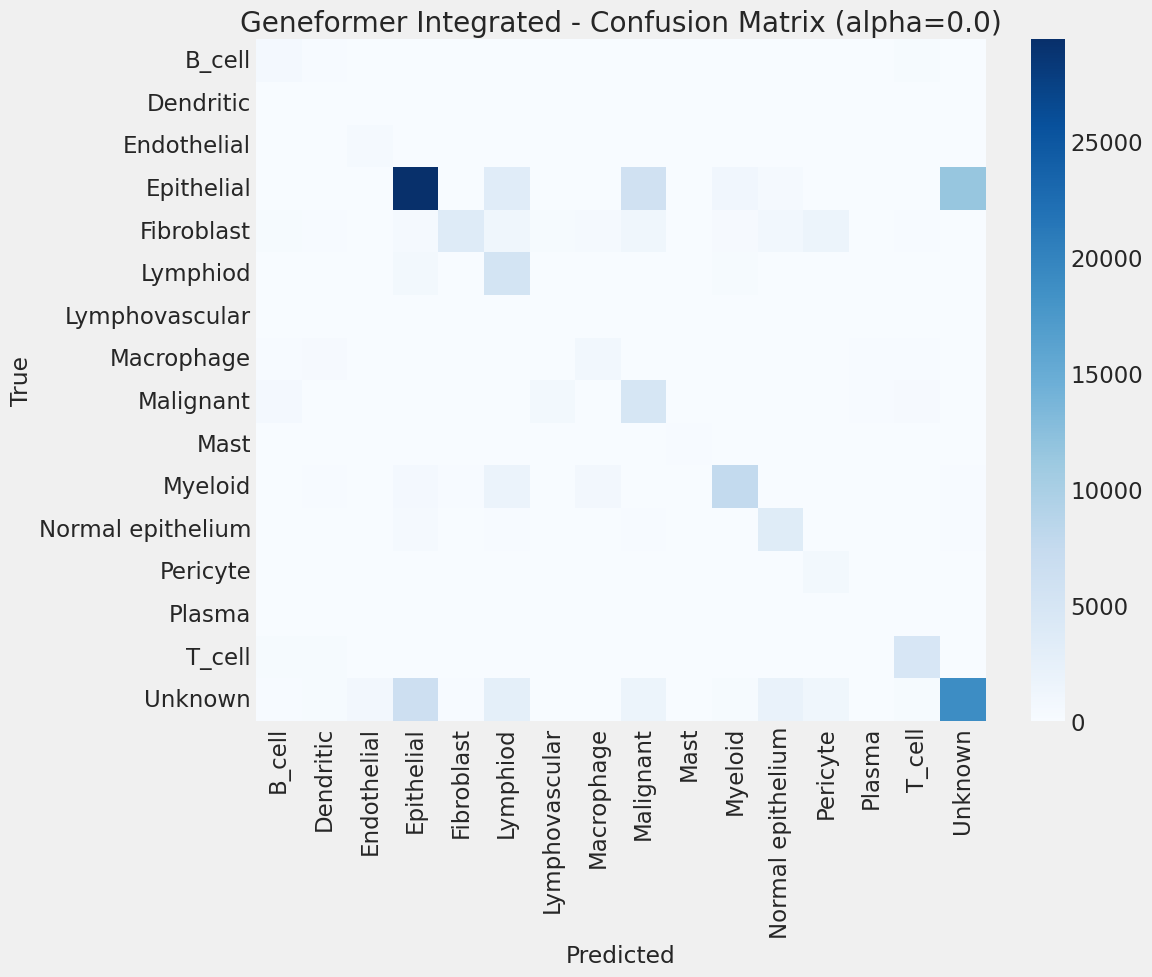

In [12]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Integrated - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_integrated_confusion_matrix_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_umap_coords_full.csv


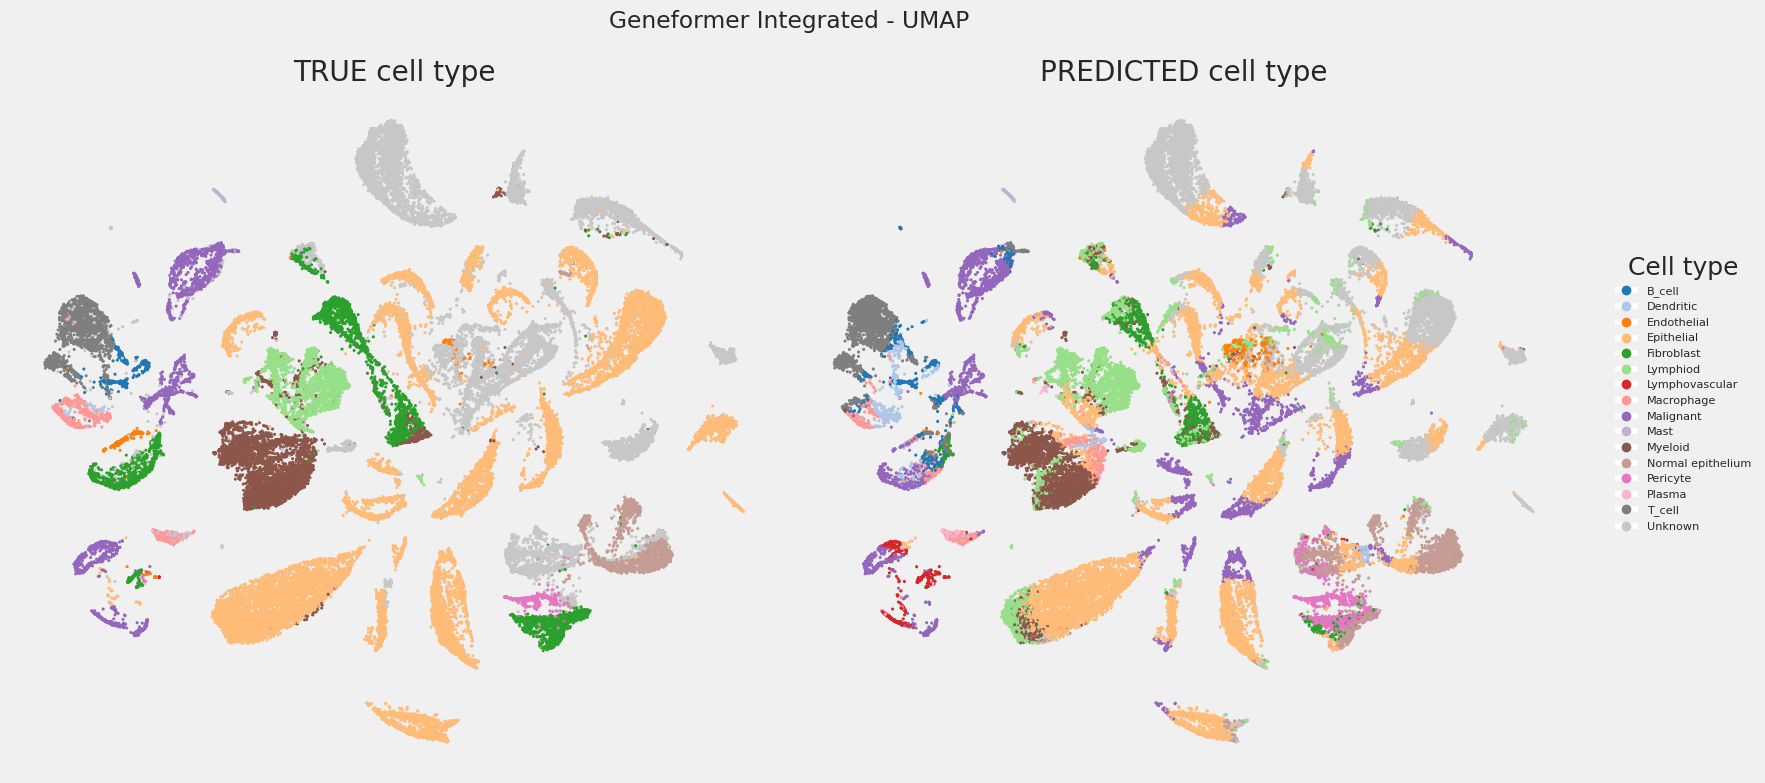

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_umap_true_pred_with_legend_full.png


In [13]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_integrated_umap_coords_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Integrated - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_umap_true_pred_with_legend_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [14]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_integrated_results_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V2-104M_CLcancer
Dataset: integrated_with_quiescence
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.5856
  precision: 0.6738
  recall: 0.5856
  f1_score: 0.6019
  auc_roc: 0.8671
  avg_precision: 0.5277

Classification report:
                   precision    recall  f1-score   support

           B_cell     0.2904    0.5588    0.3822      1106
        Dendritic     0.0438    0.6696    0.0823       112
      Endothelial     0.3897    0.5405    0.4529      1049
       Epithelial     0.7678    0.5639    0.6503     52081
       Fibroblast     0.8947    0.3329    0.4852     11155
         Lymphiod     0.3647    0.8138    0.5037      6591
   Lymphovascular     0.0126    1.0000    0.0248        16
       Macrophage     0.3582    0.4987    0.4169      1855
        Malignant     0.3467    0.7103    0.4659      6848
             Mast     0.8792    0.9295    0.9036       227
          Myeloid     0.7811    0.6710    0.7